In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Visualization and Data Preprocessing

In [4]:
# Loading Dataset
data = pd.read_excel('/content/Airlines+Data.xlsx')

In [5]:
data.head(10)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
5,1995-06-01,135
6,1995-07-01,148
7,1995-08-01,148
8,1995-09-01,136
9,1995-10-01,119


In [6]:
data.shape

(96, 2)

In [7]:
data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [8]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [9]:
data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


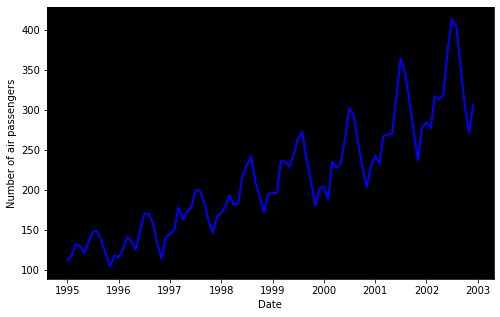

In [10]:
# Lineplot for Passengers
plt.figure(figsize=(8,5))
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
ax = plt.axes()
ax.set_facecolor("black")
plt.plot(data['Passengers'], color = 'blue', linewidth=2)

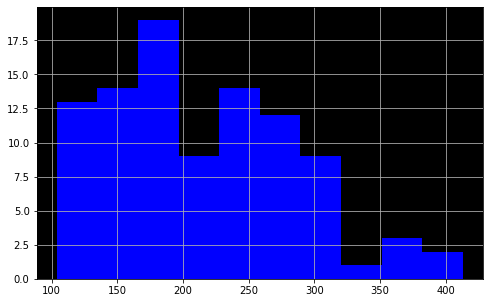

In [11]:
# Histogram
ax = plt.axes()
ax.set_facecolor("black")
data['Passengers'].hist(figsize=(8,5), color = 'blue')

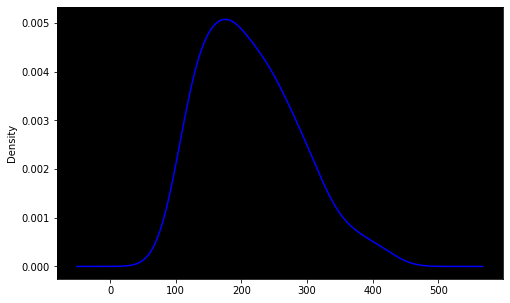

In [12]:
# Density Plot
ax = plt.axes()
ax.set_facecolor("black")
data['Passengers'].plot(kind = 'kde', figsize=(8,5), color = 'blue')

Passengers data is somewhat normally distributed

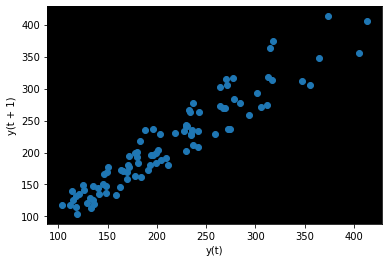

In [13]:
# Lagplot
from pandas.plotting import lag_plot

lag_plot(data['Passengers'])
ax = plt.axes()
ax.set_facecolor("black")
plt.show()

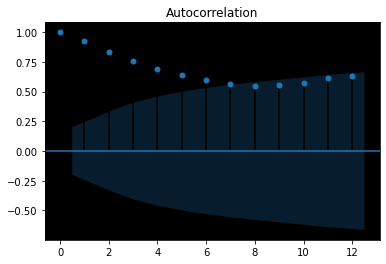

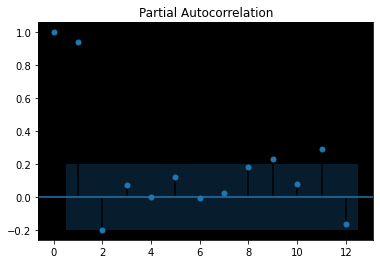

In [14]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Passengers,lags=12)
ax = plt.axes()
ax.set_facecolor("black")
tsa_plots.plot_pacf(data.Passengers,lags=12)
ax = plt.axes()
ax.set_facecolor("black")
plt.show()

## Data Driven Forecasting Methods

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Splitting Data

In [16]:
# Splitting data into Train and Test (77/33)
Train = data.head(84)
Test = data.tail(12)

#### Moving Average Method

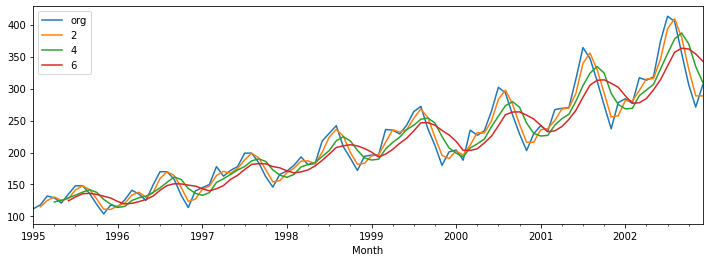

In [17]:
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,8,2):
    data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

With windows = 2, we are getting less deviation of the forecasting values with original values

#### Time series decomposition plot

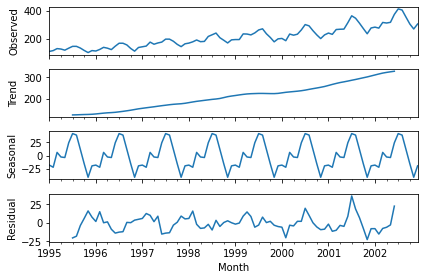

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(data.Passengers)
decompose_ts_add.plot()
plt.show()

#### Evaluation Metric RMSE

In [19]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

#### Simple Exponential Method

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model = RMSE(Test.Passengers, pred_ses)
rmse_ses_model

68.00673986206563

#### Holt method

In [22]:
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Passengers, pred_hw)
rmse_hw_model

58.57965331491723

#### Holts winter exponential smoothing with additive seasonality and additive trend

In [23]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add_model

67.32728271339978

#### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [24]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Passengers, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

70.67757090328004

## Model based Forecasting Methods

In [25]:
# Data preprocessing for models
data1 = data.copy()
data1.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [26]:
data1["t"] = np.arange(1,97)
data1["t_squared"] = data1["t"]*data1["t"]

data1["log_psngr"] = np.log(data1["Passengers"])

data1.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791


#### Splitting data

In [27]:
# Splitting data into Train and Test (77/33)
Train = data1.head(84)
Test = data1.tail(12)

#### Linear Model 

In [28]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

53.19923653480278

#### Exponential Model

In [29]:
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

46.05736110315654

#### Quadratic Model

In [30]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

48.05188897933164

#### ARIMA model

In [31]:
series = data.copy()

In [32]:
series

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [33]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


#### Persistence/ Base model

In [34]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [35]:
print(train.shape)
print(test.shape)

(60,)
(24,)


In [36]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>Predicted=229.000, Expected=203.000
>Predicted=203.000, Expected=229.000
>Predicted=229.000, Expected=242.000
>Predicted=242.000, Expected=233.000
>Predicted=233.000, Expected=267.000
>Predicted=267.000, Expected=269.000
>Predicted=269.000, Expected=270.000
>Predicted=270.000, Expected=315.000
>Predicted=315.000, Expected=364.000
>Predicted=364.000, Expected=347.000
>Predicted=347.000, Expected=312.000
>Predicted=312.000, Expected=274.000
>Predicted=274.000, Expected=237.000
>Predicted=237.000, Expected=278.000
RMSE: 29.058


In [37]:
rmse_Persistence_model = 29.058 

### ARIMA Hyperparameters

In [38]:
series = pd.read_excel('/content/Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True)

In [39]:
series

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [40]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [41]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.715)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [42]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [43]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=87.974
ARIMA(0, 0, 1) RMSE=49.107
ARIMA(0, 1, 0) RMSE=29.116
ARIMA(0, 1, 1) RMSE=28.328
ARIMA(0, 1, 2) RMSE=30.666
ARIMA(0, 1, 3) RMSE=26.562
ARIMA(0, 1, 4) RMSE=24.650
ARIMA(0, 2, 0) RMSE=35.791
ARIMA(0, 2, 1) RMSE=29.844
ARIMA(0, 2, 2) RMSE=28.876
ARIMA(1, 0, 0) RMSE=29.596
ARIMA(1, 0, 1) RMSE=28.465
ARIMA(1, 0, 2) RMSE=130.975
ARIMA(1, 1, 0) RMSE=28.830
ARIMA(1, 1, 1) RMSE=27.792
ARIMA(1, 1, 2) RMSE=25.304
ARIMA(1, 2, 0) RMSE=35.272
ARIMA(2, 0, 0) RMSE=29.093
ARIMA(2, 0, 1) RMSE=29.081
ARIMA(2, 0, 2) RMSE=29.285
ARIMA(2, 1, 0) RMSE=28.255
ARIMA(2, 1, 1) RMSE=25.236
ARIMA(2, 2, 0) RMSE=33.534
ARIMA(3, 0, 0) RMSE=28.707
ARIMA(3, 0, 1) RMSE=28.653
ARIMA(3, 1, 0) RMSE=28.832
ARIMA(3, 1, 1) RMSE=25.625
ARIMA(3, 2, 0) RMSE=34.396
ARIMA(4, 0, 0) RMSE=29.279
ARIMA(4, 0, 2) RMSE=36.826
ARIMA(4, 1, 0) RMSE=27.755
ARIMA(4, 1, 1) RMSE=26.573
ARIMA(4, 2, 0) RMSE=32.502
ARIMA(4, 2, 1) RMSE=28.363
Best ARIMA(0, 1, 4) RMSE=24.650


In [44]:
rmse_ARIMA_model = 24.650

#### Build Model based on the optimized values

In [45]:
# load data
train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

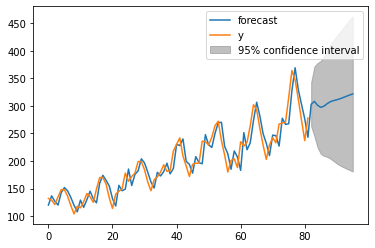

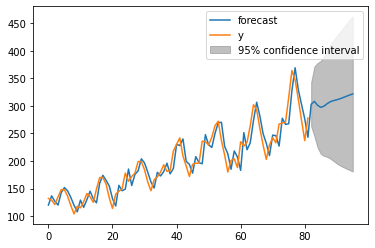

In [46]:
# fit model
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1, 96)

In [47]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

51.13515310915168

#### Combine train and test data and build final model¶

In [49]:
# fit model
data = pd.read_excel('/content/Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [50]:
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()

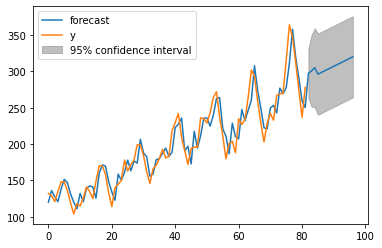

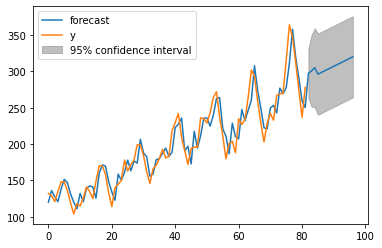

In [51]:
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,97)

In [52]:
forecast

array([297.29504564, 300.66282162, 305.18874964, 296.16873098,
       298.33910717, 300.50948336, 302.67985956, 304.85023575,
       307.02061194, 309.19098814, 311.36136433, 313.53174052])

In [53]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['Persistence/ Base model', rmse_Persistence_model], ['ARIMA Model', rmse_ARIMA_model]]


In [54]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,68.006740
1,Holt method,58.579653
2,HW exp smoothing add,67.327283
3,HW exp smoothing mult,70.677571
4,Linear Mode,53.199237
5,Exp model,46.057361
6,Quad model,48.051889
7,Persistence/ Base model,29.058000
8,ARIMA Model,24.650000
